# Inference with pre-trained models

In this notebook, we show how to perform image classification with pre-trained models using MMClassification. 

This step is also called *inference*.

## Installation

Run in command line

```
pip install openmim, mmengine
mim install mmcv-full mmcls
```

In [1]:
# copy & paste above codes to command line IF packages are NOT installed

## Config and Checkpoint File

OpenMMLab does not resemble programming raw pytorch or torchvision where we import things from modules and build models.

Instead, OpenMMLab usually works with *Config files*. (Note, it is still possible to import from OpenMMLab packages but these packages are optimized for running standard CV tasks like training/testing)

**Config file**

A Config file contains all items required to define a training *experiment*, including

- model
- dataset and data augmentation pipeline
- training algorithms and learning rate policies
- runtime config of the program

**Checkpoint file**

A pytorch `pth` file, containing the `state_dict` of a model as well as some meta information.
A checkpoint file is usually trained from a config file, using the toolbox.

We can navigate to [home page](https://github.com/open-mmlab/mmclassification) to select a model
and download corresponding config & checkpoint file using `mim`.

```
mim download mmcls --config mobilenet-v2_8xb32_in1k --dest . 
```

In [2]:
!mim download mmcls --config mobilenet-v2_8xb32_in1k --dest . 

processing mobilenet-v2_8xb32_in1k...
mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth exists in C:\Users\wangruohui\Desktop\sjtu-openmmlab-tutorial
Successfully dumped mobilenet-v2_8xb32_in1k.py to C:\Users\wangruohui\Desktop\sjtu-openmmlab-tutorial


C:\Users\wangruohui\Miniconda3\envs\mm\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## Inference using high-level API

In [3]:
from mmcls.apis import init_model, inference_model

In [4]:
model = init_model('mobilenet-v2_8xb32_in1k.py', 
                   'mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth', 
                   device='cuda:0')

load checkpoint from local path: mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth


C:\Users\wangruohui\Miniconda3\envs\mm\lib\site-packages\mmcls\apis\inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


In [5]:
result = inference_model(model, 'banana.png')

In [6]:
result

{'pred_label': 954, 'pred_score': 0.9999284744262695, 'pred_class': 'banana'}

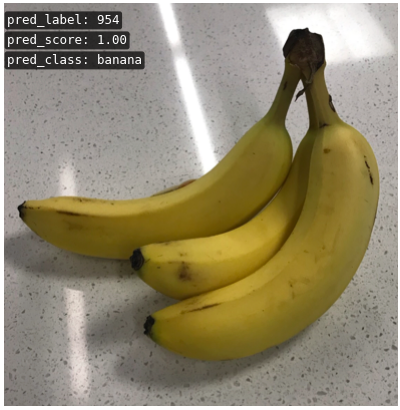

In [7]:
from mmcls.apis import show_result_pyplot

show_result_pyplot(model, 'banana.png', result)

## PyTorch codes under the hood

Let write some raw PyTorch codes to do the same thing. 

These are actual codes wrapped in high-level APIs.

### construct an `ImageClassifier`

Note: current implementation only allow configs of backbone, neck and classification head instead of Python objects. 

If you want to play with components you can construct them indivisually or fetch them as members of the constructed `ImageClassifier` object. 

In [8]:
from mmcls.models import ImageClassifier

classifier = ImageClassifier(
    backbone=dict(type='MobileNetV2', widen_factor=1.0),
    neck=dict(type='GlobalAveragePooling'),
    head=dict(
        type='LinearClsHead',
        num_classes=1000,
        in_channels=1280)
)

### Load trained parameters

In [9]:
import torch

ckpt = torch.load('mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth')
classifier.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

### Construct data preprocessing pipeline

**Important**: A models work only if image preprocessing pipelines is correct.

In [10]:
from mmcls.datasets.pipelines import Compose

test_pipeline = Compose([
    dict(type='LoadImageFromFile'),
    dict(type='Resize', size=(256, -1), backend='pillow'),
    dict(type='CenterCrop', crop_size=224),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='ImageToTensor', keys=['img']),
    dict(type='Collect', keys=['img'])
])

In [11]:
data = dict(img_info=dict(filename='banana.png'), img_prefix=None)
data = test_pipeline(data)

In [12]:
data

{'img_metas': DataContainer({'filename': 'banana.png', 'ori_filename': 'banana.png', 'ori_shape': (403, 393, 3), 'img_shape': (224, 224, 3), 'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32), 'std': array([58.395, 57.12 , 57.375], dtype=float32), 'to_rgb': True}}),
 'img': tensor([[[ 0.3309,  0.2967,  0.3138,  ...,  2.0263,  2.0092,  1.9920],
          [ 0.3481,  0.3309,  0.2282,  ...,  2.0263,  2.0092,  1.9920],
          [ 0.2796,  0.2967,  0.2967,  ...,  1.9920,  2.0263,  1.9749],
          ...,
          [ 0.1939,  0.1768,  0.2282,  ...,  0.3994,  0.3309,  0.3823],
          [ 0.1426,  0.1254,  0.2111,  ...,  0.5878,  0.5364,  0.5536],
          [-0.0116, -0.0801,  0.1597,  ...,  0.5707,  0.5536,  0.5364]],
 
         [[ 0.3803,  0.3803,  0.3803,  ...,  2.1660,  2.1485,  2.1134],
          [ 0.4153,  0.4153,  0.3102,  ...,  2.1835,  2.1310,  2.1134],
          [ 0.3452,  0.3803,  0.3803,  ...,  2.1134,  2.1485,  2.1134],
          ...,
          [ 0.2752,  

#### equivalent in `torchvision` 

In [13]:
from PIL import Image
from torchvision.transforms import Compose, Resize, CenterCrop, Normalize, ToTensor

tv_transform = Compose([Resize(256), 
                        CenterCrop(224), 
                        ToTensor(),
                        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                        ])

image = Image.open('banana.png').convert('RGB')
tv_data = tv_transform(image)

### Forward through the model

In [15]:
## IMPORTANT: set the classifier to eval mode
classifier.eval()

imgs = data['img'].unsqueeze(0)
imgs = tv_data.unsqueeze(0)

with torch.no_grad():
    # class probabilities
    prob = classifier.forward_test(imgs)[0]
    # features
    feat = classifier.extract_feat(imgs, stage='neck')[0]
    
print(len(prob))
print(prob.argmax().item())
print(feat.shape)

1000
954
torch.Size([1, 1280])
